In [2]:
# from resnet import *
import torch
import torch
import torch.nn as nn 
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn.functional as F 
from sklearn.model_selection import KFold
import os
import io
import cv2
from PIL import *
import PIL.ImageOps
import requests
from PIL import Image
import numpy as np

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn.functional as F 
from torch.optim import lr_scheduler
import time
import copy
from sklearn.model_selection import KFold
import os
import io
import cv2
from PIL import *
import PIL.ImageOps
from PIL import Image
from sklearn.metrics import roc_curve, auc
import math 

In [3]:
model = models.alexnet(pretrained=True)
print(model.eval())

# move the input and model to GPU for speed if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

device(type='cuda', index=0)

In [6]:
for i in os.listdir('D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_1_patch\\Train'):
    print(i)
    link_train = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_1_patch\\Train\\'+i+''
    link_test = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_2_patch\\natural_test\\'+i+''
    model_address = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_2_patch\\model_baseline\\{}.pth'.format(i,i)

    transform    = transforms.Compose([
                                        
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

    training_dataset = datasets.ImageFolder(link_train ,transform = transform)
    testing_dataset = datasets.ImageFolder(link_test,transform = transform)

    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=48, shuffle=True)
    # testing data 

    val_dataset, test_dataset = random_split(testing_dataset,[math.floor(len(testing_dataset)*0.6), math.ceil(len(testing_dataset)*0.4)])

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=False)
    testing_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)

    print("Training data set after removing two instances : {}".format(len(training_dataset)))
    print("Complete Val data set : {}".format(len(val_dataset)))
    print("Complete Test data set : {}".format(len(test_dataset)))
    classes = ('Live', 'Spoof')

    for param in model.parameters():
        param.requires_grad = False

    import torch.nn as nn

    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.fc=nn.Linear(n_inputs,2)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


    splits = KFold(n_splits= 3, shuffle = True, random_state = 42)

    epochs = 15
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    for e in range(epochs):
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0
        for inputs, labels in training_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            #loss.requres_grad = False
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
        else:
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)

                    _, val_preds = torch.max(val_outputs, 1)
                    val_running_loss += val_loss.item()
                    val_running_corrects += torch.sum(val_preds == val_labels.data)
        
            epoch_loss = running_loss/len(training_loader.dataset)
            epoch_acc = running_corrects.float()/ len(training_loader.dataset)
            running_loss_history.append(epoch_loss)
            running_corrects_history.append(epoch_acc)

            val_epoch_loss = val_running_loss/len(val_loader.dataset)
            val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset)
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            print('epoch :', (e+1))
            print('training acc {:.4f} '.format(epoch_acc.item()))
            print('validation acc {:.4f} '.format( val_epoch_acc.item()))

    torch.save(model.state_dict(),model_address) 
# #ADD address here with filename

Live
Training data set after removing two instances : 768
Complete Val data set : 614
Complete Test data set : 410


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Live
Training data set after removing two instances : 768
Complete Val data set : 614
Complete Test data set : 410
torch.Size([410, 2])
area under curce: 0.9412604722010662


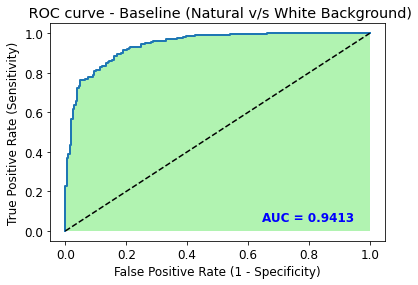

compute_eer 14.389756283320644
Spoof
Training data set after removing two instances : 2048
Complete Val data set : 1228
Complete Test data set : 820
torch.Size([820, 2])
area under curce: 0.6945197982105462


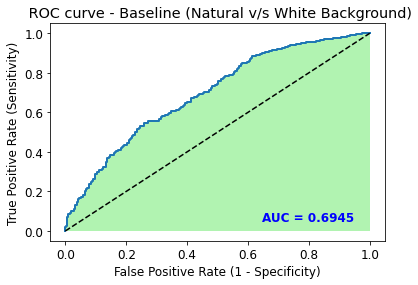

compute_eer 37.8045878545593


In [8]:
# from resnet import *
import matplotlib.pyplot as plt
import torch.nn as nn 
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn.functional as F 
from sklearn.model_selection import KFold
import os
import io
import cv2
from PIL import *
import PIL.ImageOps
import requests
from PIL import Image
import numpy as np
#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn.functional as F 
from torch.optim import lr_scheduler
import time
import copy
from sklearn.model_selection import KFold
import os
import io
import cv2
from PIL import *
import PIL.ImageOps
from PIL import Image
from sklearn.metrics import roc_curve, auc,roc_auc_score

model = models.resnet18(pretrained=True)
# print(model.eval())

# move the input and model to GPU for speed if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




import math 

for i in os.listdir('D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_1_patch\\Train'):
    print(i)
    link_train = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_1_patch\\Train\\'+i+''
    link_test = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_2_patch\\natural_test\\'+i+''
    model_address = 'D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_2_patch\\model_baseline\\{}.pth'.format(i,i)

    text_file = i

    transform    = transforms.Compose([
                                        
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

    training_dataset = datasets.ImageFolder(link_train ,transform = transform)
    testing_dataset = datasets.ImageFolder(link_test,transform = transform)

    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=48, shuffle=True)
    # testing data 

    val_dataset, test_dataset = random_split(testing_dataset,[math.floor(len(testing_dataset)*0.6), math.ceil(len(testing_dataset)*0.4)])

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=False)
    testing_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False)


    print("Training data set after removing two instances : {}".format(len(training_dataset)))
    print("Complete Val data set : {}".format(len(val_dataset)))
    print("Complete Test data set : {}".format(len(test_dataset)))
    classes = ('Live', 'Spoof')

    for param in model.parameters():
        param.requires_grad = False

    import torch.nn as nn

    n_inputs = model.fc.in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.fc=nn.Linear(n_inputs,2)
    # model.to(device)
   # print(model.eval())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


    model.load_state_dict(torch.load(model_address))

    def get_all_preds(model,loader):
        all_preds = torch.tensor([])
        #   all_preds.to(device)
        for batch in loader:
            images,labels = batch
            #   images = images.to(device)
            #   labels = labels.to(device)
        

            preds = model(images)
            all_preds = torch.cat((all_preds , preds),dim=0)
        return all_preds


    with torch.no_grad():
        prediction_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 32)
        test_pred = get_all_preds(model,prediction_loader)
        
    print(test_pred.shape)
    test_labels = [label for _, label in test_dataset]
    # print(test_labels)

    test_set = torch.FloatTensor(test_labels)


    def get_num_correct(preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    pred_correct = get_num_correct(test_pred,test_set)
    # print('total correct:',pred_correct)
    # test accuracy


    stacked = torch.stack((test_set,test_pred.argmax(dim=1)),dim=1)



    t11=[]
    p11=[]
    for p in stacked:
        t1,p1=p.tolist()
        t11.append(t1)
        p11.append(p1)
        
        

    from sklearn.metrics import confusion_matrix
    # print('Confusion Matrix',confusion_matrix(t11,p11))


    m = nn.Softmax(dim=1)
    # input = torch.randn(2, 3)
    # output = m(input)
    test_prediction = m(test_pred)
    
    

    far, tpr, threshold = roc_curve(test_set ,
                                        test_prediction [:,1],
                                        drop_intermediate = True )
    
     #calculate AUC of model
    auc = roc_auc_score(test_set ,test_prediction [:,1])
    print('area under curce:',auc)
 
    #print(far, tpr,threshold)
    plt.figure(figsize=(6,4))
   
    plt.plot(far, tpr, linewidth=2)

    plt.plot([0,1], [0,1], 'k--' )

    plt.rcParams['font.size'] = 12
    plt.fill_between(far, tpr, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
    plt.title(' ROC curve - Baseline (Natural v/s White Background)')

    plt.xlabel('False Positive Rate (1 - Specificity)')

    plt.ylabel('True Positive Rate (Sensitivity)')

    plt.show()
   

    def compute_eer(fpr,tpr,threshold):
        """ Returns equal error rate (EER) and the corresponding threshold. """
        fnr = 1-tpr
        abs_diffs = np.abs(fpr - fnr)
        min_index = np.argmin(abs_diffs)
        eer = np.mean((fpr[min_index], fnr[min_index]))
        return eer*100

    print('compute_eer',compute_eer(far,tpr,threshold))
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    Accuracies = accuracy_score(t11,p11)
    Precision = precision_score(t11,p11)
    Recall = recall_score(t11,p11)
    F1Score = f1_score(t11,p11)
    
    with open("D:\\Fall 2021\\Applied ML - AIT 736\\final new\\Experiment_2_patch\\"+text_file+".txt", "a") as f:
        print('accuracy:',pred_correct/len(test_dataset),file=f)
        print('Accuracy:',Accuracies,file=f)
        print('Precision',Precision,file=f)
        print('Recall',Recall,file=f)
        print('F1Score',F1Score,file=f)
        print('Confusion Matrix',confusion_matrix(t11,p11),file=f)
        print('compute_eer',compute_eer(far,tpr,threshold),file=f)
        print('area under the curve',auc,file=f)